# Import Libraries

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC
from qiskit.primitives import Sampler
from qiskit_aer import Aer
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



In [3]:
# Load your dataset
full_df = pd.read_csv('heart.csv')  # Replace with your dataset

# Randomly sample 300 rows
df = full_df.sample(n=300, random_state=42)  # random_state ensures reproducibility

# Save the sampled dataset (optional)
#df.to_csv('sampled_heart.csv', index=False)

Dataset Attributes

1. **Age:** The age of the patient in years.
2. **Sex:** The gender of the patient.  
   - `M`: Male  
   - `F`: Female  
3. **ChestPainType:** Type of chest pain the patient experienced.  
   - `TA`: Typical Angina (chest pain due to reduced blood flow)  
   - `ATA`: Atypical Angina (less common, more vague symptoms)  
   - `NAP`: Non-Anginal Pain (pain not related to heart issues)  
   - `ASY`: Asymptomatic (no chest pain)  
4. **RestingBP:** The patient’s resting blood pressure in mm Hg.
5. **Cholesterol:** The patient’s serum cholesterol level in mg/dl.
6. **FastingBS:** Fasting blood sugar level.  
   - `1`: Fasting blood sugar > 120 mg/dl  
   - `0`: Fasting blood sugar ≤ 120 mg/dl  
7. **RestingECG:** Results of the patient's resting electrocardiogram.  
   - `Normal`: Normal ECG  
   - `ST`: ST-T wave abnormality (e.g., T-wave inversions or ST elevation/depression)  
   - `LVH`: Left ventricular hypertrophy (thickening of the heart muscle)  
8. **MaxHR:** Maximum heart rate achieved by the patient during exercise (numeric value between 60 and 202).
9. **ExerciseAngina:** Whether the patient experienced exercise-induced chest pain.  
   - `Y`: Yes  
   - `N`: No  
10. **Oldpeak:** Depression in the ST segment during exercise (numeric value).
11. **ST_Slope:** The slope of the ST segment during peak exercise.  
   - `Up`: Upsloping  
   - `Flat`: Flat  
   - `Down`: Downsloping  
12. **HeartDisease:** Target variable indicating whether the patient has heart disease.  
   - `1`: Heart disease present  
   - `0`: No heart disease  

---

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
668,63,F,ATA,140,195,0,Normal,179,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
377,65,M,ASY,160,0,1,ST,122,N,1.2,Flat,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
807,54,M,ATA,108,309,0,Normal,156,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 668 to 28
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             300 non-null    int64  
 1   Sex             300 non-null    object 
 2   ChestPainType   300 non-null    object 
 3   RestingBP       300 non-null    int64  
 4   Cholesterol     300 non-null    int64  
 5   FastingBS       300 non-null    int64  
 6   RestingECG      300 non-null    object 
 7   MaxHR           300 non-null    int64  
 8   ExerciseAngina  300 non-null    object 
 9   Oldpeak         300 non-null    float64
 10  ST_Slope        300 non-null    object 
 11  HeartDisease    300 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 30.5+ KB


In [6]:
# Show Shape of Data
print(f"Number of Rows : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Rows : 300
Number of Columns : 12


In [7]:
# check for null values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,300.0,53.363333,9.123346,28.0,47.75,54.0,60.00,76.0
RestingBP,300.0,131.243333,18.257288,80.0,120.00,130.0,140.00,200.0
Cholesterol,300.0,192.383333,116.160495,0.0,158.25,221.0,263.00,564.0
FastingBS,300.0,0.270000,0.444701,0.0,0.00,0.0,1.00,1.0
MaxHR,300.0,137.236667,26.910865,60.0,120.00,138.0,157.25,202.0
Oldpeak,300.0,0.835333,0.967715,-1.1,0.00,0.6,1.50,4.0
HeartDisease,300.0,0.593333,0.492032,0.0,0.00,1.0,1.00,1.0


In [8]:
df.describe(include='object').T

,count,unique,top,freq
Sex,300,2,M,249
ChestPainType,300,4,ASY,153
RestingECG,300,3,Normal,184
ExerciseAngina,300,2,N,183
ST_Slope,300,3,Flat,140


In [7]:
# check duplication

df.duplicated().sum()

0

**Outliers Detection**

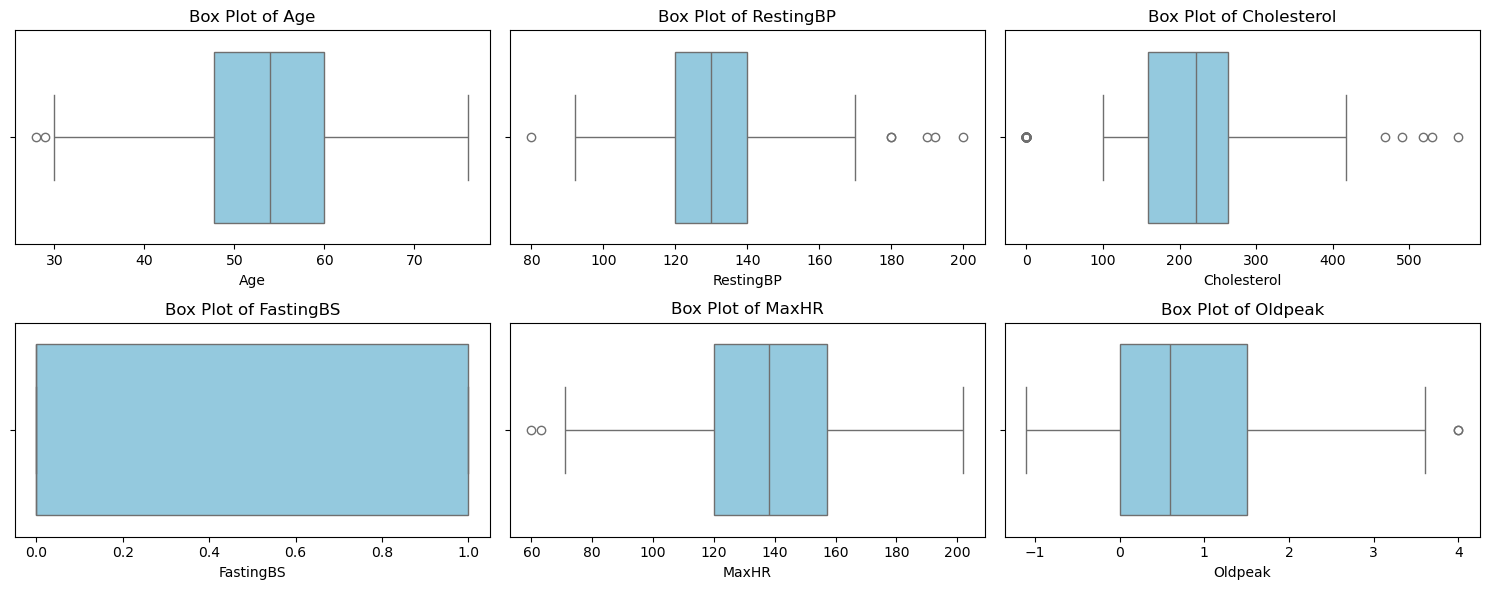

In [9]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [10]:
# to find exactly in numbers

def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)           # 25th percentile
        Q3 = df[col].quantile(0.75)           # 75th percentile
        IQR = Q3 - Q1                         # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

Age: 2 outliers detected
RestingBP: 6 outliers detected
Cholesterol: 69 outliers detected
FastingBS: 0 outliers detected
MaxHR: 2 outliers detected
Oldpeak: 2 outliers detected


In [11]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)      # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)      # Third quartile (75%)
        IQR = Q3 - Q1                          # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

# The New of Shape Cleaned Data
print(f"Number of Row : {df_cleaned.shape[0]}")


df = df_cleaned

Number of Row : 280


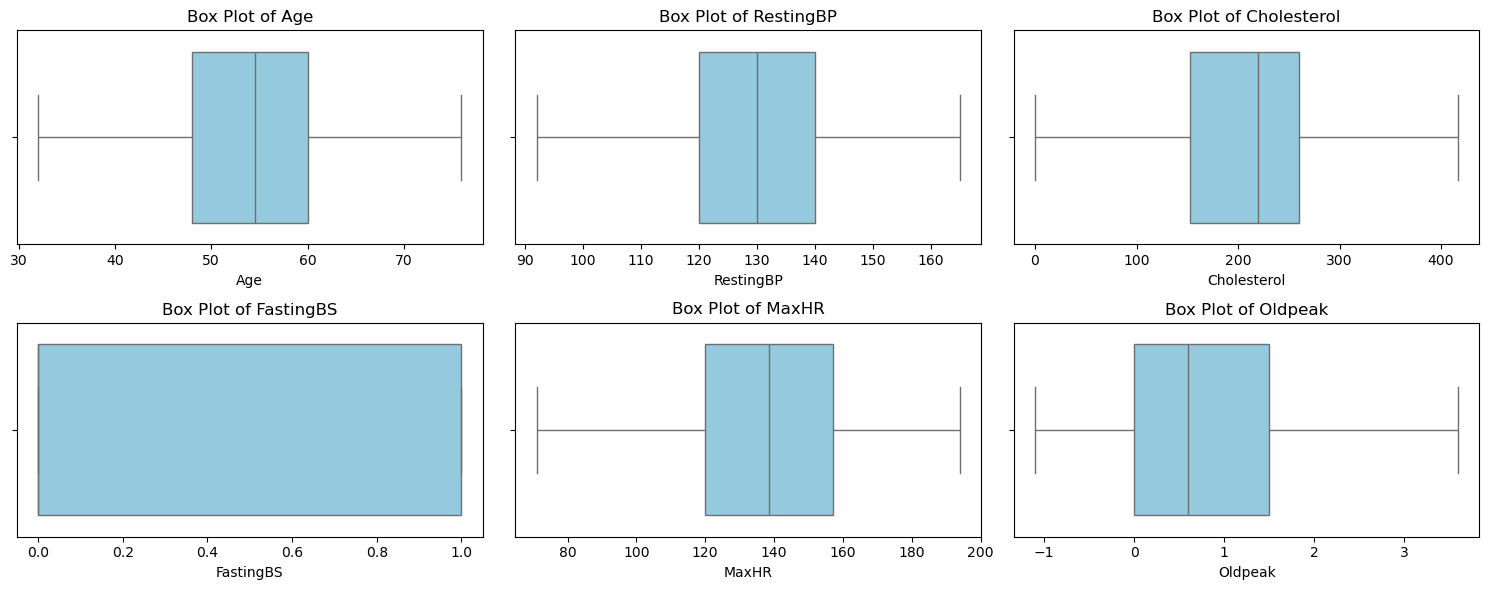

In [12]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

<Axes: xlabel='Age', ylabel='Count'>

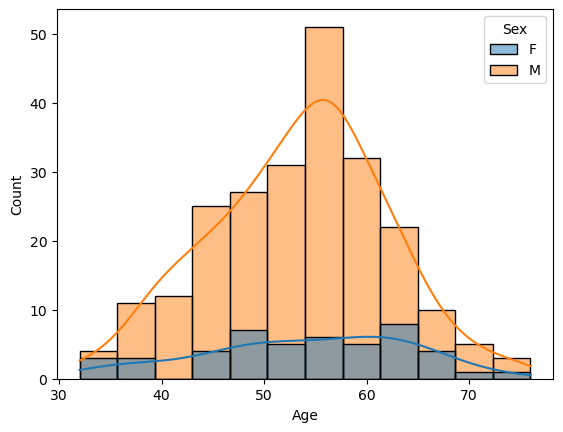

In [13]:
sns.histplot(x='Age', data=df, kde=True, hue='Sex')

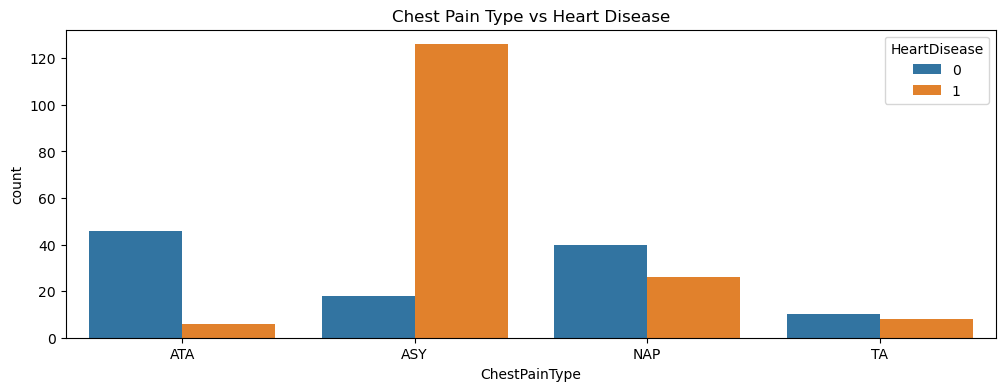

In [14]:
# countplot to visualize the distribution of categorical features
plt.figure(figsize=(12,4),dpi=100)
sns.countplot(x='ChestPainType', data=df, hue='HeartDisease')
plt.title('Chest Pain Type vs Heart Disease')
plt.show()

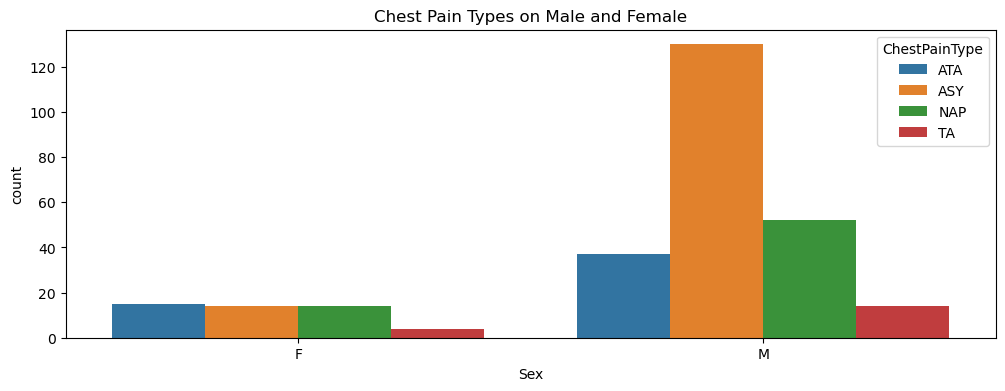

In [15]:
plt.figure(figsize=(12,4),dpi=100)
sns.countplot(x='Sex', data = df, hue='ChestPainType')
plt.title('Chest Pain Types on Male and Female')
plt.show()

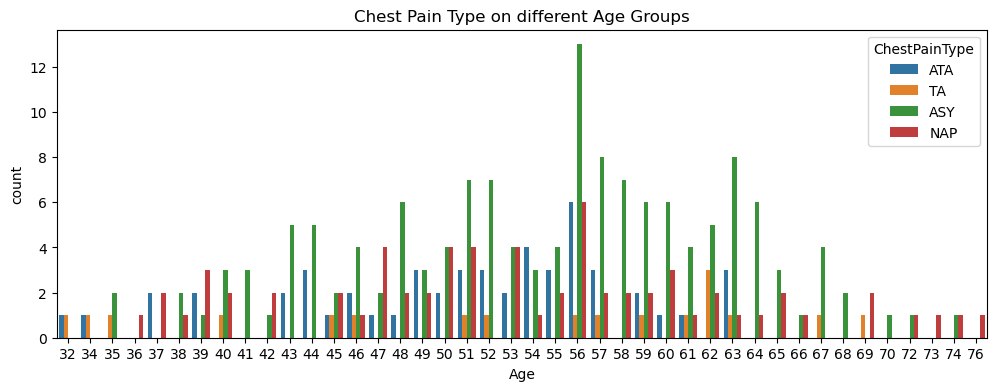

In [16]:
plt.figure(figsize=(12,4),dpi=100)
sns.countplot(x='Age', data=df, hue='ChestPainType')
plt.title('Chest Pain Type on different Age Groups')
plt.show()

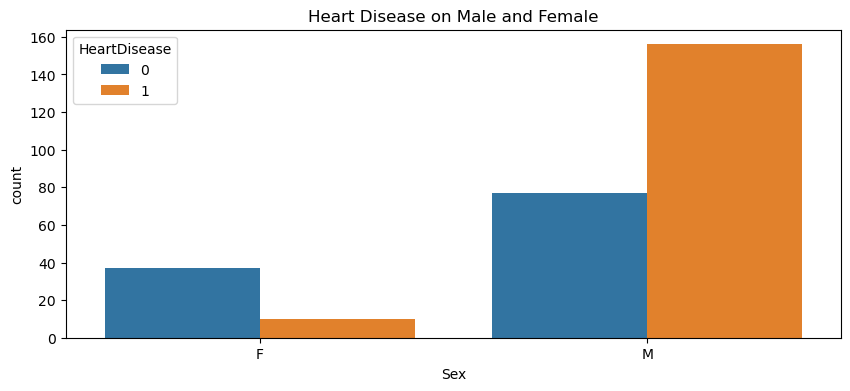

In [17]:
plt.figure(figsize=(10,4),dpi=100)
sns.countplot(x='Sex', data=df, hue='HeartDisease')
plt.title('Heart Disease on Male and Female')
plt.show()

<Figure size 1500x1000 with 0 Axes>

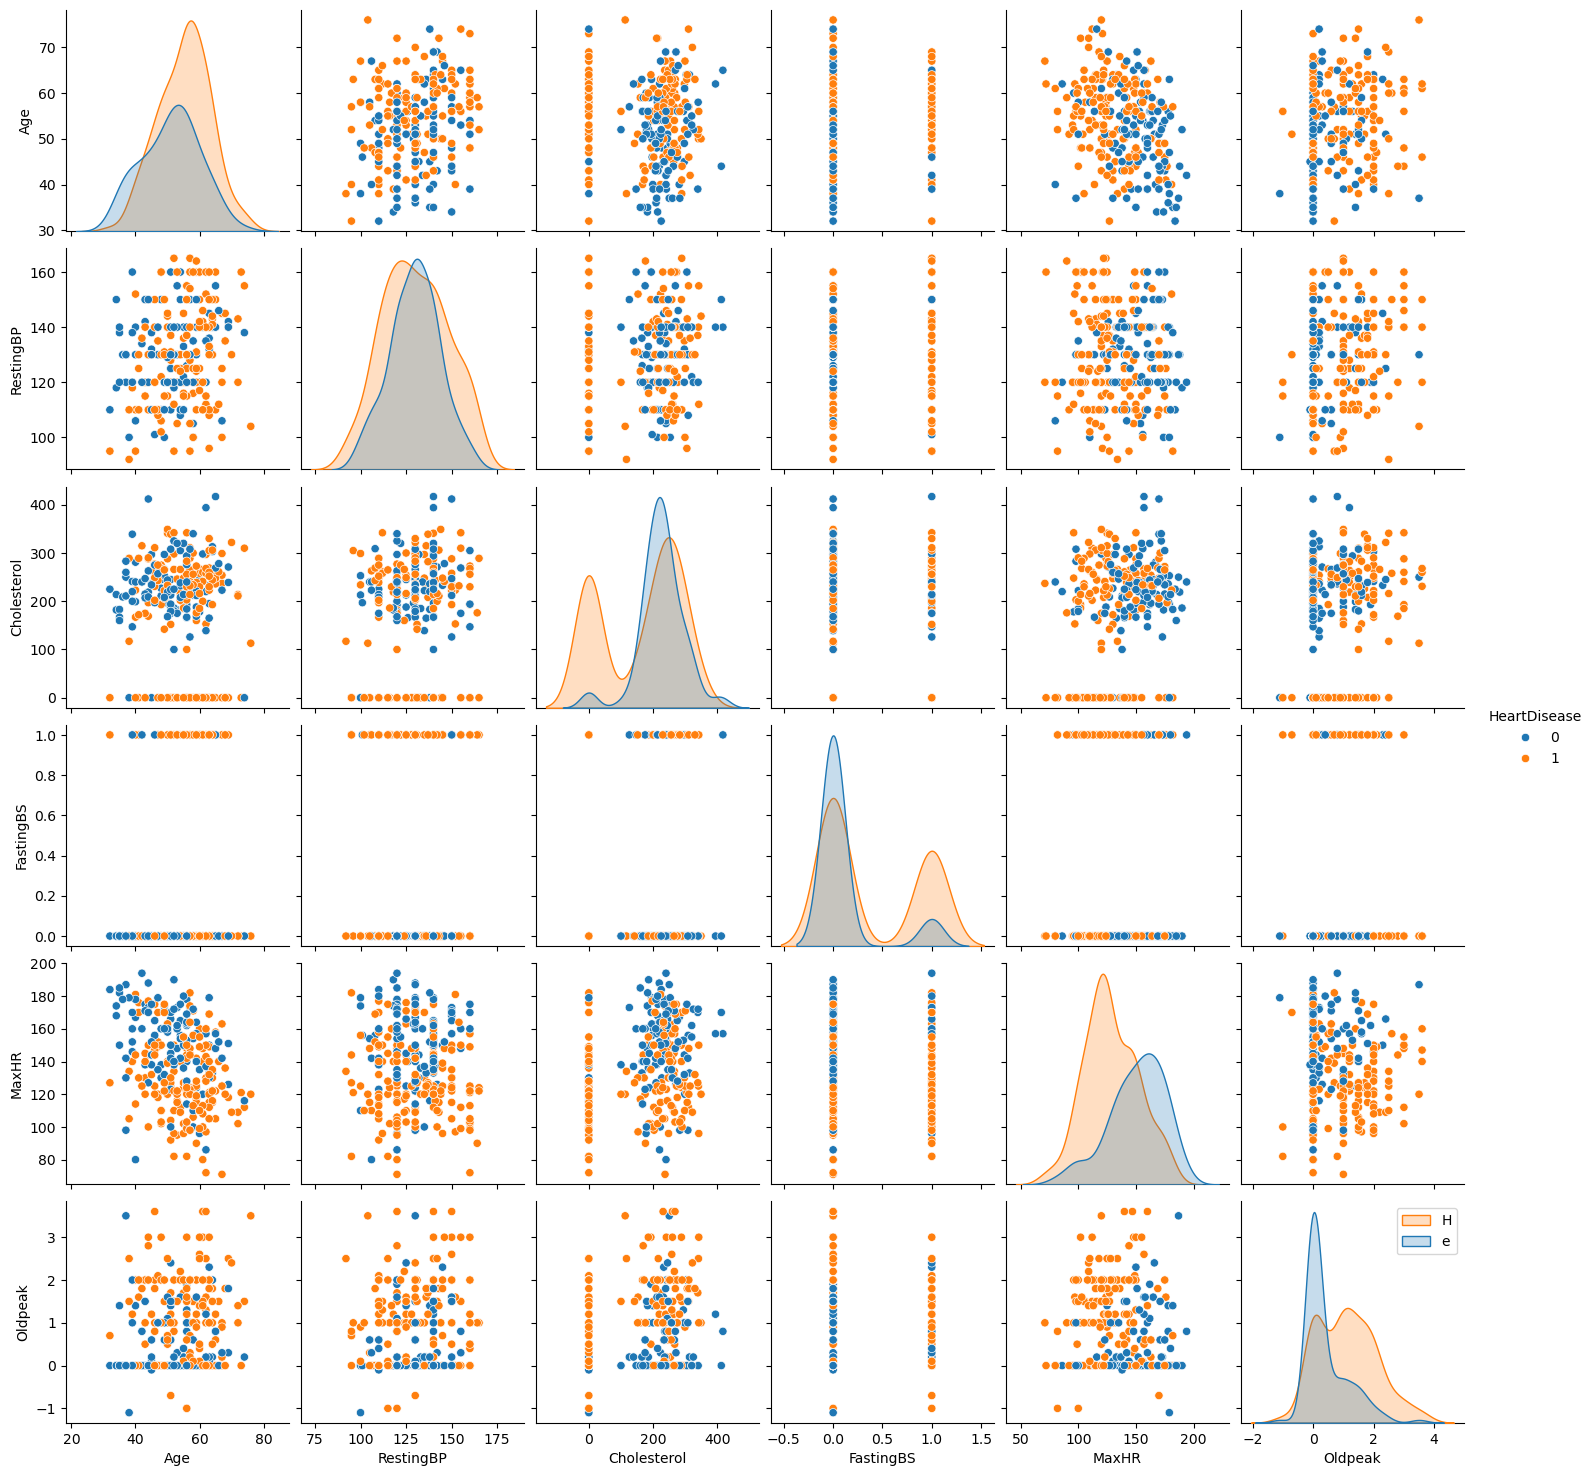

In [18]:
# Pair plot: It shows the relationship between numerical features and also shows the distribution and relationship of each numerical columns between each combination.
plt.figure(figsize=(15,10))
sns.pairplot(df, hue='HeartDisease')
plt.legend('HeartDisease')
plt.show()

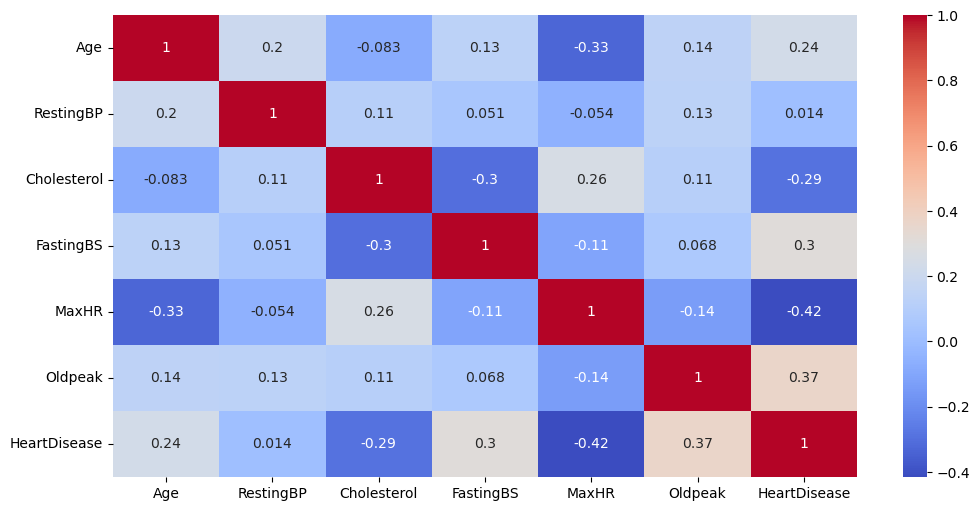

In [19]:
#correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# Data Preprocessing

In [11]:
from sklearn.preprocessing import LabelEncoder

# Separate categorical and numerical columns
cate_df = df[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]
num_df = df.drop(columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

# One-hot encoding for nominal categorical columns
df_cate_dummy = pd.get_dummies(cate_df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

# Ordinal encoding for ordinal categorical columns
label_encoder = LabelEncoder()
df_cate_dummy['Sex'] = label_encoder.fit_transform(cate_df['Sex'])  # Male: 1, Female: 0
df_cate_dummy['ExerciseAngina'] = label_encoder.fit_transform(cate_df['ExerciseAngina'])  # Yes: 1, No: 0

# Combine encoded categorical columns with numerical columns
df_processed = pd.concat([num_df, df_cate_dummy], axis=1)

# Display the final preprocessed dataset
df_processed.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
668,63,140,195,0,179,0.0,0,0,0,True,False,False,True,False,False,True
377,65,160,0,1,122,1.2,1,1,0,False,False,False,False,True,True,False
535,56,130,0,0,122,1.0,1,1,1,False,False,False,False,False,True,False
807,54,108,309,0,156,0.0,0,1,0,True,False,False,True,False,False,True
793,67,125,254,1,163,0.2,1,1,0,False,False,False,True,False,True,False


In [12]:
# Convert boolean columns to integers
df_processed = df_processed.astype(int)
df_processed.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
668,63,140,195,0,179,0,0,0,0,1,0,0,1,0,0,1
377,65,160,0,1,122,1,1,1,0,0,0,0,0,1,1,0
535,56,130,0,0,122,1,1,1,1,0,0,0,0,0,1,0
807,54,108,309,0,156,0,0,1,0,1,0,0,1,0,0,1
793,67,125,254,1,163,0,1,1,0,0,0,0,1,0,1,0


## Model Development

**Variational Quantum Classifier (VQC)** from Qiskit

The Variational Quantum Classifier (VQC) are often used in a hybrid quantum-classical framework, where quantum circuits are used to perform computations that are then combined with classical algorithms for optimization.

1. Hybrid Quantum-Classical Approach:

- VQC combines classical machine learning techniques with quantum computing. It uses a quantum circuit to represent a model and classical optimization techniques to train that model.
- The quantum circuit is parameterized, meaning it has adjustable parameters that can be tuned to minimize a loss function.

2. Quantum Circuits:

- The VQC uses quantum circuits to encode the input data into quantum states. These circuits can be designed using various quantum gates and can represent complex functions.
- The parameters of the quantum circuit are adjusted during training to improve classification accuracy.

3. Loss Function:

- The VQC typically uses a loss function (e.g., cross-entropy loss) to measure how well the model is performing. The goal is to minimize this loss function through optimization.

4. Optimization:

- Classical optimization algorithms (like COBYLA, SPSA, or gradient descent) are used to adjust the parameters of the quantum circuit based on the loss function's output.
- The optimization process involves running the quantum circuit multiple times to evaluate the loss and update the parameters accordingly.

5. Output:

- After training, the VQC can classify new data points by encoding them into quantum states and running the trained quantum circuit to obtain predictions.

**Key Components of VQC**  

a) Feature Map: A quantum circuit that encodes classical data into quantum states. It transforms the input features into a form suitable for quantum processing.      

b) Ansatz: A parameterized quantum circuit that represents the model. The ansatz can be designed in various ways, depending on the problem and the desired complexity.  

c) Quantum Instance is replaced by sampler: Represents the quantum backend (simulator or real quantum device) on which the quantum circuit is executed.


In [46]:
X = df_processed.drop('HeartDisease', axis=1)
y = df_processed['HeartDisease']

#  Feature Scaling: Standardization(StandardScaler) is used to scale the data to have a mean of 0 and a variance of 1
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
X.shape

(280, 15)

In [48]:
X_train.shape

(224, 15)

**Dimensionality Reduction:**
-  Use techniques like Principal Component Analysis (PCA) to reduce the number of features to 4

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Update X_train and X_test
X_train = X_train_reduced
X_test = X_test_reduced

## Variational Quantum Classifier (VQC)

In [52]:
from qiskit.circuit import Parameter, ParameterVector
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA

# Define feature map and ansatz with unique parameter names
num_qubits = 4
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=3)

# Initialize the sampler
sampler = Sampler()

# Initialize VQC with the updated feature_map and ansatz
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    sampler=sampler,
)

C:\Users\HEMASREE\AppData\Local\Temp\ipykernel_30640\710417997.py:12: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [54]:
vqc.fit(X_train, y_train_encoded)
y_pred_encoded = vqc.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)

In [55]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"VQC Accuracy: {accuracy * 100:.2f}%")

VQC Accuracy: 48.21%


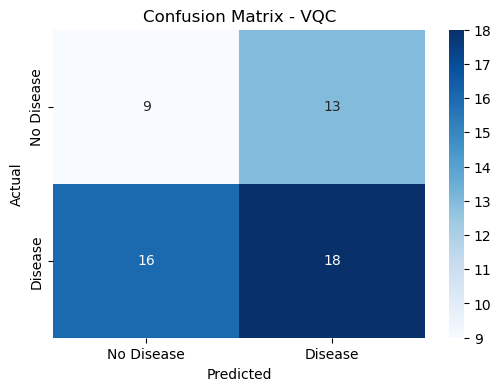

In [57]:
# Step 4: Visualizations
# Confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred, "VQC")

## Quantum Support Vector Classifier (QSVC)

- The Quantum Support Vector Classifier (QSVC) is a quantum version of the classical Support Vector Machine (SVM) algorithm. It leverages quantum computing principles to potentially enhance the performance of SVMs, especially in high-dimensional spaces.
- SVMs aim to find the optimal hyperplane that separates data points of different classes in a high-dimensional space. The goal is to maximize the margin between the closest points of the classes (support vectors).
- Quantum States: In QSVC, data points are represented as quantum states. This allows for the encoding of high-dimensional data in a more compact form, leveraging the principles of superposition and entanglement.

- Quantum Kernels: QSVC can utilize quantum kernels, which are computed using quantum circuits. These kernels can capture complex relationships in the data that may be difficult for classical kernels to model.

In [23]:

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)


C:\Users\HEMASREE\AppData\Local\Temp\ipykernel_18292\2419974504.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\HEMASREE\AppData\Local\Temp\ipykernel_18292\2419974504.py:5: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity = ComputeUncompute(sampler=sampler)


In [70]:
qsvc = QSVC(quantum_kernel=quantum_kernel)

In [71]:
# Train the QSVC model
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x00000287791B5CA0>,
     random_state=42, shrinking=True, tol=0.001, verbose=False)

In [72]:
# Make predictions
y_pred = qsvc.predict(X_test)

In [80]:
# Calculate accuracy
accuracy_qsvc = accuracy_score(y_test, y_pred)
print(f"QSVC Accuracy: {accuracy_qsvc * 100:.2f}%")

QSVC Accuracy: 60.71%


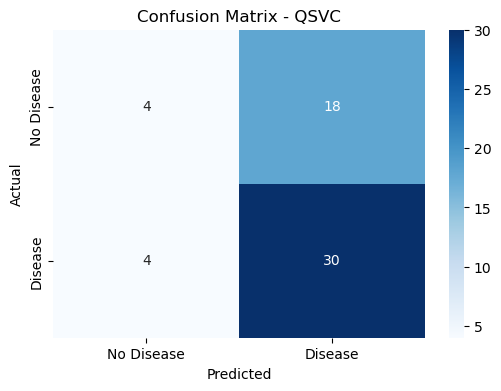

In [74]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred, "QSVC")

# Build  classical ML model

**SVC**

In [ ]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%")

SVM Accuracy: 85.71%


**Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

Random Forest Accuracy: 80.36%


# Visualization

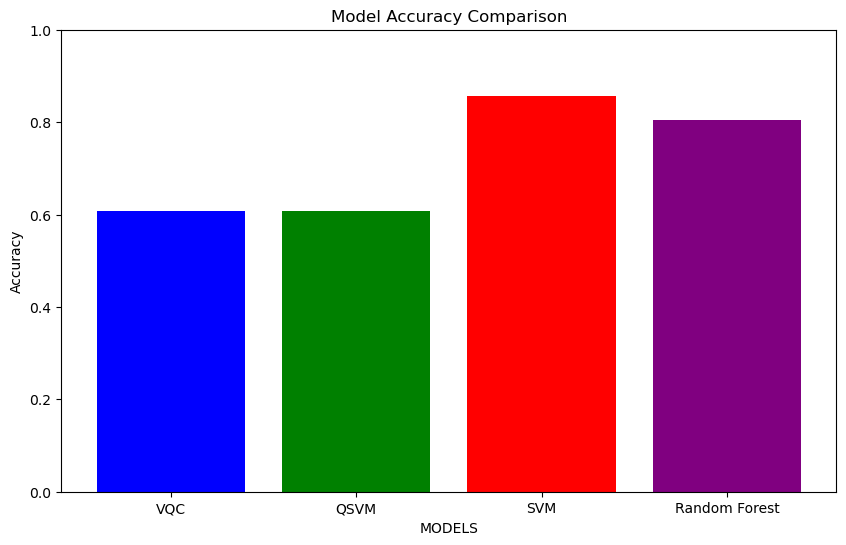

In [81]:
# Accuracy comparison bar plot
models = ["VQC","QSVM", "SVM", "Random Forest"]
accuracies = [accuracy, accuracy_qsvc, accuracy_svm, accuracy_rf]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=["blue", "green", "red", "purple", "orange"])
plt.xlabel("MODELS")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

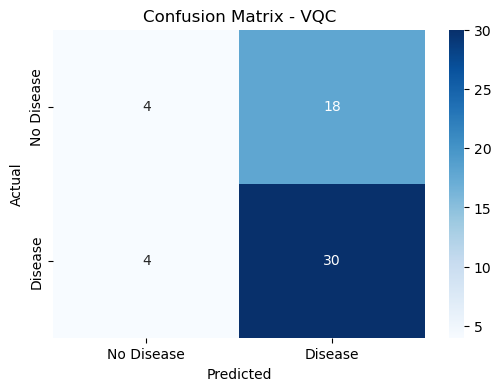

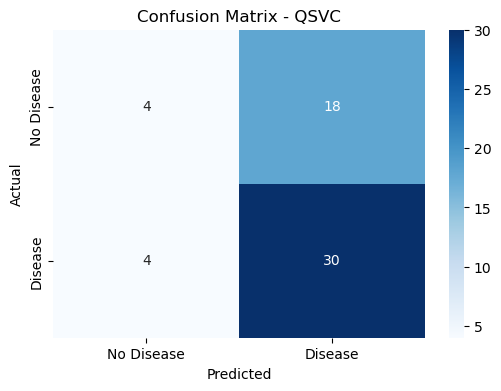

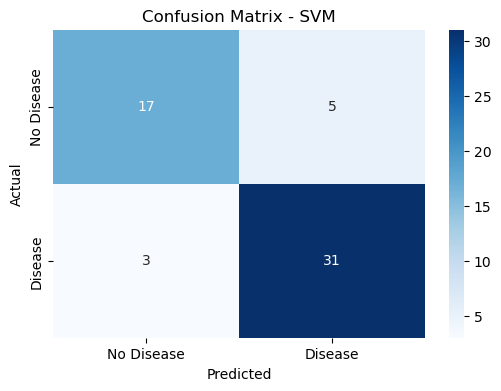

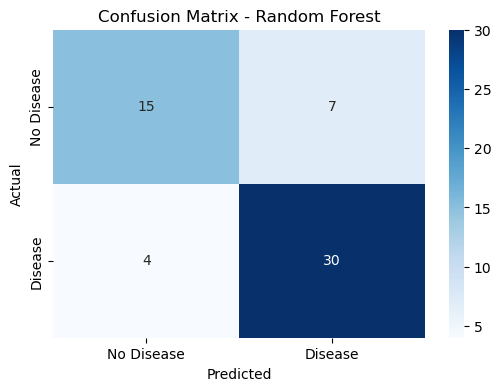

In [82]:
# Confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred, "VQC")
plot_confusion_matrix(y_test, y_pred, "QSVC")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

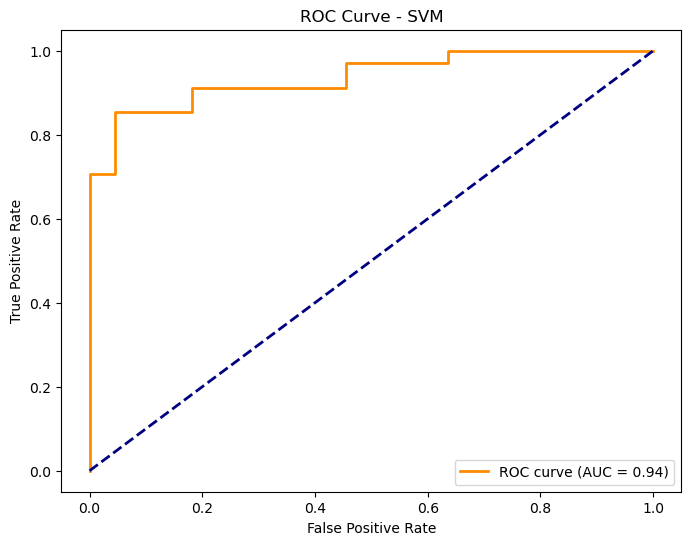

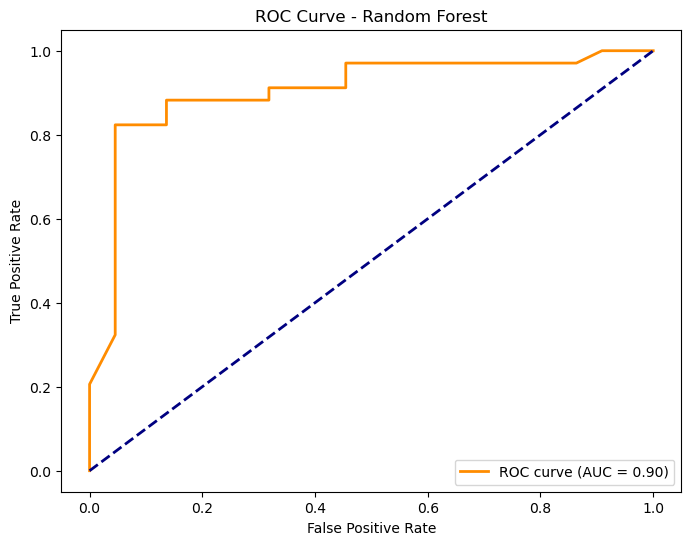

In [84]:
# ROC curves for classical models
from sklearn.metrics import roc_curve, auc 

def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(y_test, svm.decision_function(X_test), "SVM")
plot_roc_curve(y_test, rf.predict_proba(X_test)[:, 1], "Random Forest")

# Conclusion

1. In this study, we evaluated the performance of four machine learning models—Variational Quantum Classifier (VQC), Quantum Support Vector Classifier (QSVC), Support Vector Machine (SVM), and Random Forest—on a heart attack prediction dataset. The accuracy scores obtained for each model are as follows:

    - VQC: 48.21%

    - QSVC: 60.71%

    - SVM: 85.71%

    - Random Forest: 80.36%

2. The classical models (SVC and Random Forest) outperform the quantum models (VQC and QSVM) on this dataset.

3. The QSVC performed better than the VQC, indicating that kernel-based quantum methods may be more suitable for this dataset than variational quantum approaches.

4. Quantum machine learning is still in its early stages, and models like this are experimental. They may not always perform well on classical datasets without careful tuning.

5. The choice of feature map, ansatz, and optimizer significantly impacts the model's performance. Experimentation is required to find the best combination.